# <ins>**Is there a significant difference between holding stocks over an extended period, and using EMAs in a dynamic trading strategy?**</ins>

This project's objective is to find out if it is convenient to use the EMAs crossover strategy. For this, I'll use the relationships between EMAs with different time frames (12, 26, 50 and 100 days). 

Caveats:
The comparison here uses only one technical indicator while an actual trader would use multiple indicators to minimize bias and risk. This script may not be efficient as I minimized the use of an AI to correcly reflect my progress in python.

In [48]:
# Packages and initial variable

import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import pprint

nvda = yf.Ticker("NVDA")

## First Steps

In [71]:
# This function is used to limit the dictionary output for github format (I did it with AI)
def print_limited_dict(d, limit=20):
    limited_items = dict(itertools.islice(d.items(), limit))
    
    # Use pprint for vertical formatting
    pprint.pprint(limited_items)
    
    if len(d) > limit:
        print(f"...and {len(d) - limit} more items.")

# Ticker's data
print_limited_dict(nvda.info,limit=20)

{'address1': '2788 San Tomas Expressway',
 'auditRisk': 7,
 'boardRisk': 10,
 'city': 'Santa Clara',
 'companyOfficers': [{'age': 60,
                      'exercisedValue': 217327152,
                      'fiscalYear': 2024,
                      'maxAge': 1,
                      'name': 'Mr. Jen-Hsun  Huang',
                      'title': 'Co-Founder, CEO, President & Director',
                      'totalPay': 7491487,
                      'unexercisedValue': 0,
                      'yearBorn': 1963},
                     {'age': 56,
                      'exercisedValue': 0,
                      'fiscalYear': 2024,
                      'maxAge': 1,
                      'name': 'Ms. Colette M. Kress',
                      'title': 'Executive VP & CFO',
                      'totalPay': 1510765,
                      'unexercisedValue': 0,
                      'yearBorn': 1967},
                     {'age': 68,
                      'exercisedValue': 0,
                   

In [50]:
# Filtering 5 years of stock's price history with daily frequency.
hist_5y = nvda.history(interval='1d',
                       period='5y')
hist_5y.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-09-12 00:00:00-04:00,4.632864,4.687603,4.576882,4.584844,327840000,0.0,0.0
2019-09-13 00:00:00-04:00,4.518162,4.555235,4.483079,4.526870,324592000,0.0,0.0
2019-09-16 00:00:00-04:00,4.451730,4.518411,4.441280,4.483826,231832000,0.0,0.0
2019-09-17 00:00:00-04:00,4.490545,4.509455,4.444017,4.505225,223048000,0.0,0.0
2019-09-18 00:00:00-04:00,4.498258,4.513933,4.391517,4.478104,258152000,0.0,0.0


In [51]:
# Were there any splits that may have impacted the stock's price?
close_5y = hist_5y.loc[:,['Close','Stock Splits']]
close_5y.head()

,Close,Stock Splits
Date,,
2019-09-12 00:00:00-04:00,4.584844,0.0
2019-09-13 00:00:00-04:00,4.526870,0.0
2019-09-16 00:00:00-04:00,4.483826,0.0
2019-09-17 00:00:00-04:00,4.505225,0.0
2019-09-18 00:00:00-04:00,4.478104,0.0


During the 5-year period 2019-2024 there were splits on 2021-07-20 (1:4) and 2024-06-10 (1:10).

In [52]:
# Split dates and ratios
close_5y[close_5y['Stock Splits'] != 0]

,Close,Stock Splits
Date,,
2021-07-20 00:00:00-04:00,18.578415,4.0
2024-06-10 00:00:00-04:00,121.779999,10.0


As it can be seen below, the stock's price doesn't have any significant difference before and after each split. Therefore I won't adjust them.

In [53]:
split_2021 = (close_5y.index <= '2021-07-22') & (close_5y.index >= '2021-07-16')
split_2024 = (close_5y.index <= '2024-06-12') & (close_5y.index >= '2024-06-06')

print(f"Stock split from 2021: \n {close_5y.loc[split_2021,['Close','Stock Splits']]} \n")
print(f"Stock split from 2024: \n {close_5y.loc[split_2024,['Close','Stock Splits']]}")

Stock split from 2021: 
                                Close  Stock Splits
Date                                              
2021-07-16 00:00:00-04:00  18.128229           0.0
2021-07-19 00:00:00-04:00  18.745863           0.0
2021-07-20 00:00:00-04:00  18.578415           4.0
2021-07-21 00:00:00-04:00  19.374975           0.0
2021-07-22 00:00:00-04:00  19.558645           0.0 

Stock split from 2024: 
                                 Close  Stock Splits
Date                                               
2024-06-06 00:00:00-04:00  120.988060           0.0
2024-06-07 00:00:00-04:00  120.878075           0.0
2024-06-10 00:00:00-04:00  121.779999          10.0
2024-06-11 00:00:00-04:00  120.910004           0.0
2024-06-12 00:00:00-04:00  125.199997           0.0


## <ins>**Exponential Moving Average (EMA) Calcs**:</ins>
    EMA(t) = [Price(t) - EMA(t-1)] * 2 / (period + 1) + EMA(t-1)

In [54]:
# EMA(t)

close_5y['EMA_12d'] = close_5y['Close'].ewm(span=12,adjust=False).mean()
close_5y['EMA_26d'] = close_5y['Close'].ewm(span=26,adjust=False).mean()
close_5y['EMA_50d'] = close_5y['Close'].ewm(span=50,adjust=False).mean()
close_5y['EMA_100d'] = close_5y['Close'].ewm(span=100,adjust=False).mean()

close_5y.sort_index(ascending=False)#.iloc[:5,[0,2,3,4,5]]

#close_5y.drop(['EMA_12d_26d','Signal_12d_26d'],axis=1)

,Close,Stock Splits,EMA_12d,EMA_26d,EMA_50d,EMA_100d
Date,,,,,,
2024-09-12 00:00:00-04:00,119.690002,0.0,114.023319,115.572762,115.542057,109.554549
2024-09-11 00:00:00-04:00,116.910004,0.0,112.993013,115.243383,115.372754,109.349793
2024-09-10 00:00:00-04:00,108.099998,0.0,112.280833,115.110053,115.310009,109.197061
2024-09-09 00:00:00-04:00,106.470001,0.0,113.040985,115.670858,115.604295,109.219224
2024-09-06 00:00:00-04:00,102.830002,0.0,114.235709,116.406926,115.977123,109.274764
...,...,...,...,...,...,...
2019-09-18 00:00:00-04:00,4.478104,0.0,4.541527,4.561652,4.571985,4.578182
2019-09-17 00:00:00-04:00,4.505225,0.0,4.553059,4.568336,4.575817,4.580203
2019-09-16 00:00:00-04:00,4.483826,0.0,4.561756,4.573385,4.578698,4.581718


## <ins>**EMAs Comparison**</ins>

### _12 vs 26 days_

#### Table Creation

In [55]:
cols_1 = ['Close','EMA_12d','EMA_26d']

crossover_12d_26d = close_5y.loc[:,cols_1]

crossover_12d_26d.loc[:,'EMA_comp'] = crossover_12d_26d.loc[:,'EMA_12d'] - crossover_12d_26d.loc[:,'EMA_26d']

crossover_sorted = crossover_12d_26d.sort_index(ascending=False)
crossover_sorted.head()

,Close,EMA_12d,EMA_26d,EMA_comp
Date,,,,
2024-09-12 00:00:00-04:00,119.690002,114.023319,115.572762,-1.549443
2024-09-11 00:00:00-04:00,116.910004,112.993013,115.243383,-2.250370
2024-09-10 00:00:00-04:00,108.099998,112.280833,115.110053,-2.829220
2024-09-09 00:00:00-04:00,106.470001,113.040985,115.670858,-2.629873
2024-09-06 00:00:00-04:00,102.830002,114.235709,116.406926,-2.171217


#### Line Chart with Closing Price and EMAs

                          stock_info       value
Date                                            
2024-09-12 00:00:00-04:00      Close  119.690002
2024-09-12 00:00:00-04:00    EMA_12d  114.023319
2024-09-12 00:00:00-04:00    EMA_26d  115.572762


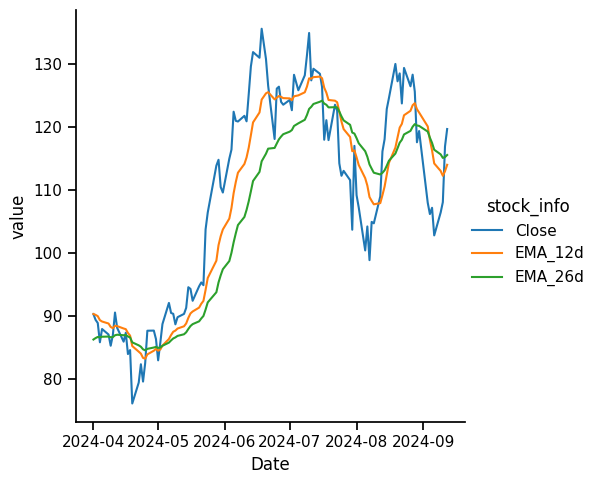

In [56]:
# Parsing for line chart
EMA_melt_1 = crossover_sorted.reset_index().melt(id_vars='Date',
                                                value_vars=['Close','EMA_12d','EMA_26d'],
                                                var_name='stock_info',
                                                value_name='value').set_index('Date').sort_index(ascending=False)
print(EMA_melt_1.head(3))

# Last months chart
long_mask_1 = (EMA_melt_1.index >= '2024-04-01')
long_EMA_comp_1 = EMA_melt_1.loc[long_mask_1]

sns.color_palette('colorblind',3)

sns.set_context('notebook')

sns.relplot(kind='line',
            data=long_EMA_comp_1,
            x=long_EMA_comp_1.index,
            y='value',
            hue='stock_info',
            hue_order=['Close','EMA_12d','EMA_26d'])

plt.show()

#### Finding the Intersections

In [57]:
mask_down_1 = (crossover_12d_26d['EMA_comp'].shift(-1) < 0) & (crossover_12d_26d['EMA_comp'] > 0).shift(1)
mask_up_1 = (crossover_12d_26d['EMA_comp'].shift(-1) > 0) & (crossover_12d_26d['EMA_comp'] < 0).shift(1)

print(f'Downward direction: \n {crossover_12d_26d.loc[mask_down_1].head(2)} \n')
print(f'Upward direction: \n {crossover_12d_26d.loc[mask_up_1].head(2)}')

Downward direction: 
                               Close   EMA_12d   EMA_26d  EMA_comp
Date                                                             
2020-03-10 00:00:00-04:00  6.504643  6.658461  6.629893  0.028568
2020-03-11 00:00:00-04:00  6.140646  6.578797  6.593652 -0.014855 

Upward direction: 
                               Close   EMA_12d   EMA_26d  EMA_comp
Date                                                             
2019-10-10 00:00:00-04:00  4.553991  4.462693  4.468872 -0.006179
2019-10-11 00:00:00-04:00  4.627640  4.488070  4.480633  0.007437


_Each crossover will be marked using the following logic:_
- 'Sell' signal for the instance in which the 12-day-EMA crosses the 26-day-EMA downwards.
- 'Buy' signal for the instance in which the 12-day-EMA crosses the 26-day-EMA upwards.

In [58]:
crossover_12d_26d.loc[(crossover_12d_26d['EMA_comp'].shift(1) > 0) & (crossover_12d_26d['EMA_comp'] < 0), 'Signal'] = 'Sell'
crossover_12d_26d.loc[(crossover_12d_26d['EMA_comp'].shift(1) < 0) & (crossover_12d_26d['EMA_comp'] > 0), 'Signal'] = 'Buy'

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)  

print(f'Downward direction: \n {crossover_12d_26d[mask_down_1].head(3)} \n')
print(f'Upward direction: \n {crossover_12d_26d[mask_up_1].head(3)}')

Downward direction: 
                                Close    EMA_12d    EMA_26d  EMA_comp Signal
Date                                                                       
2020-03-10 00:00:00-04:00   6.504643   6.658461   6.629893  0.028568    NaN
2020-03-11 00:00:00-04:00   6.140646   6.578797   6.593652 -0.014855   Sell
2020-10-29 00:00:00-04:00  12.989198  13.300114  13.280768  0.019345    NaN 

Upward direction: 
                               Close   EMA_12d   EMA_26d  EMA_comp Signal
Date                                                                    
2019-10-10 00:00:00-04:00  4.553991  4.462693  4.468872 -0.006179    NaN
2019-10-11 00:00:00-04:00  4.627640  4.488070  4.480633  0.007437    Buy
2020-04-03 00:00:00-04:00  6.076864  6.138769  6.146263 -0.007494    NaN


To properly work with these signals, I'll filter the crossover_12d_26d table to keep only those rows.

In [59]:
# row mask
signal_only_1 = crossover_12d_26d['Signal'].isin(['Buy','Sell'])

# Filtered table
crossover_12d_26d_sig = crossover_12d_26d.loc[signal_only_1,['Close','Signal']]

To compare the stock's holding to the EMA crossover strategy, the first thing you'd do is to buy said stock. Therefore, the first signal has to be 'Buy'. The last one could be to buy, but for simplicity I'll set it to a selling one. (I may change this in following updates)

In [60]:
def first_last_signals(crossover_sig_df):
    
    # Check the first signal
    first_signal = crossover_sig_df['Signal'].iloc[0] 
    
    # Check the last signal
    last_signal = crossover_sig_df['Signal'].iloc[-1] 
    
    # If first signal is 'Sell', filter it out
    if first_signal == 'Sell': 
        crossover_sig_df = crossover_sig_df.iloc[1:] 
        
    # If last signal is 'Buy', filter it out    
    if last_signal == 'Buy': 
        crossover_sig_df = crossover_sig_df.iloc[:-1]

In [61]:
# Filtered crossover_sig_df
first_last_signals(crossover_12d_26d_sig)

#### Profit/Loss Ratios

In [62]:
# EMAs crossover profit/loss ratio(t)
crossover_12d_26d_sig['P&L_ratio_12d_26d'] = crossover_12d_26d_sig['Close'].shift(-1) / crossover_12d_26d_sig['Close']

# Stock holding profit/loss total ratio
crossover_12d_26d_rate = crossover_12d_26d_sig['P&L_ratio_12d_26d'].product()

#print(crossover_12d_26d_sig)

#### Total Profit/Loss

In [63]:
# Stock's holding profit/loss
Holding_earnings_1 = crossover_12d_26d_sig['Close'].iloc[-1] - crossover_12d_26d_sig['Close'].iloc[0]

# Calculo ganancia/pérdida total en valor absoluto entre el 2019-10-10 y 2024-09-04
crossover_12d_26d_earnings = crossover_12d_26d_sig['Close'].iloc[0] * (crossover_12d_26d_rate - 1)

In [64]:
print(f'\033[1m EMA crossover strategy earnings: \033[0m {round(crossover_12d_26d_earnings,4)} USD')
print(f'\033[1m Stock holding strategy earnings: \033[0m {round(Holding_earnings_1,4)} USD')
print(f'\033[1m Difference: \033[0m {round(crossover_12d_26d_earnings - Holding_earnings_1,15)}')

 EMA crossover strategy earnings:  101.5824 USD
 Stock holding strategy earnings:  101.5824 USD
 Difference:  -2.8e-14


## Test

### Table Creation

In [65]:
cols = ['Close','EMA_12d','EMA_50d']

crossover_12d_50d = close_5y.loc[:,cols]
crossover_12d_50d.loc[:,'EMA_comp'] = crossover_12d_50d.loc[:,'EMA_12d'] - crossover_12d_50d.loc[:,'EMA_50d']
crossover_12d_50d.head()

,Close,EMA_12d,EMA_50d,EMA_comp
Date,,,,
2019-09-12 00:00:00-04:00,4.584844,4.584844,4.584844,0.000000
2019-09-13 00:00:00-04:00,4.526870,4.575925,4.582570,-0.006646
2019-09-16 00:00:00-04:00,4.483826,4.561756,4.578698,-0.016942
2019-09-17 00:00:00-04:00,4.505225,4.553059,4.575817,-0.022758
2019-09-18 00:00:00-04:00,4.478104,4.541527,4.571985,-0.030458
